# random field toy analysis

For an more detailed description of using this method in the context of a bump hunt,  [see this notebook](https://github.com/naodell/nllfit/blob/master/examples/gross_vitells_higgs.ipynb).  In this notebook, I will do a more abstract GV analysis: rather than starting from a real world analysis challenge, I'm just going to generate random data and estimate the density of the points.  The density will serve as our random field.

In [5]:
# imports and configuration

%cd '/home/naodell/work/projects/nllfit'
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.stats import norm, chi2

from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV
from tqdm import tqdm_notebook, tnrange

from nllfit import Parameters, ScanParameters, Model, NLLFitter
import nllfit.fit_tools as ft
import nllfit.lookee as lee

# %qtconsole

/home/naodell/work/projects/nllfit


The first step will be to produce our toy data.  In the simplest case, each on the manifold will be distributed according to a $\chi^{2}_{k}$.  Let's limit our focus to a two dimensional manifold.  To get to the $\chi^{2}$ manifold, we first generate a $n\times m$ normally distributed variates.  Since this is the case of $\mu=0$ and $\sigma=1$, we can get the $\chi^{2}$ variates by squaring each of the normally distributed variates.

In [168]:
n  = 1000 #xrange(50, 500, 10)
bw = 0.05
npix = (100, 100)
x, y = np.linspace(0, 1, npix[0]), np.linspace(0, 1, npix[1])
xx, yy = np.meshgrid(x, y)
z = np.array([xx.ravel(), yy.ravel()]).transpose()

uvals  = np.linspace(1., 25., 120)
toys   = np.random.rand(50, n, 2)
ecn    = []
scores = []
for toy in tqdm_notebook(toys):
    kde  = KernelDensity(kernel='gaussian', bandwidth=bw).fit(toy)
    norm = n*bw
    s    = (np.exp(kde.score_samples(z)) - 1/(np.pi*bw**2))**2
    s    = s.reshape(npix[0], npix[1])
    ec   = [lee.calculate_euler_characteristic((s > u) + 0.) for u in uvals]
    scores.append(s)
    ecn.append(ec)

scores = np.array(scores)
smax   = np.max(scores, axis=0)
ecn    = np.array(ecn)

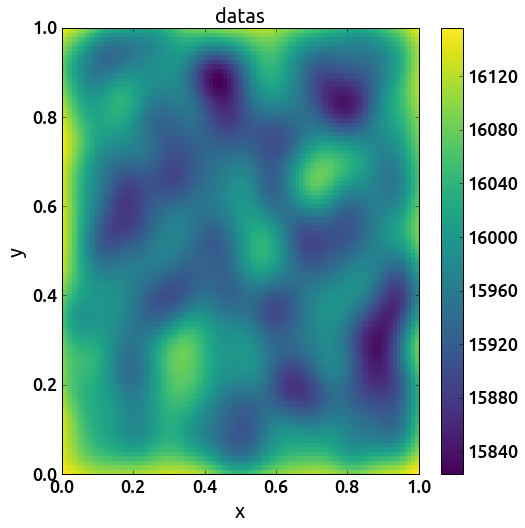

In [169]:
plt.figure(figsize=(8,8))
plt.pcolormesh(x, y, scores[-1].reshape(npix[0], npix[1]), cmap='viridis')
plt.colorbar()

# plt.scatter(toy[:,0], toy[:,1])
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('x')
plt.ylabel('y')

plt.title('datas')

Now the E.C. expansion coefficients, $\mathcal{N}_{d}$ can be calculated.

In [145]:
param_init = [1., 1.]
param_bnds = [(1., np.inf), (1., np.inf)]
nvals      = lee.get_GV_coefficients(uvals, ecn, param_init, param_bnds, kvals=[1], scales=[1])
print nvals

[ 1.  1.]


The performance can be seen by comparing the probability of observing a fluctuation for a given $u$, the expectation of the EC, and the GV prediction.

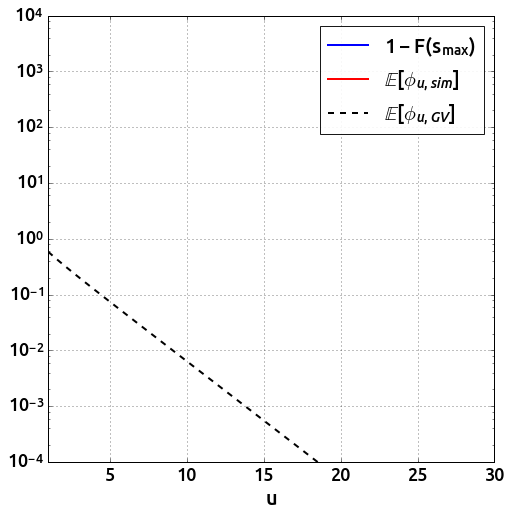

In [146]:
# make some plots
h, b = np.histogram(smax, bins=300, range=(0., 30.))
h    = 1 - np.cumsum(h).astype(float)/smax.size

plt.figure(figsize=(8,8))
plt.plot(b[1:], h, 'b-')
plt.plot(uvals, np.mean(ecn, axis=0), 'r-')
plt.plot(uvals, lee.exp_phi_u(uvals, nvals, 1), 'k--')

plt.xlabel(r'$\sf u$')
plt.ylabel(r'')
plt.xlim(1, 30)
plt.ylim(1e-4, 1e4)
plt.legend([r'$\sf 1 - F(s_{max})$', r'$\mathbb{E}[\phi_{u,sim}]$', r'$\mathbb{E}[\phi_{u,GV}]$'])
plt.yscale('log')
plt.show()

So for this $\chi^{2}$ field it is clear that the expectation of the E.C. and the survival function for likelihood ratio correspond very closely.  This gives credence to the statement that for sufficiently large excursions, $u$,

$$\mathbb{E}[\phi_{u}] \approx \mathbb{P}[q_{\theta} > u]$$